In [123]:
import mkl_fft
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import fftpack
from scipy.spatial.distance import cdist
from scipy.stats import binned_statistic_dd, binned_statistic_2d, binned_statistic
from tqdm import tqdm

In [124]:
def sinkhorn(p, q, C, beta=0.01, eps=1e-12, max_iter=200, tol=1e-10, patience=10, plot=True):
    '''
    p, q - distributions
    C - cost matrix
    beta - regularization parameter 
    '''
    n, m = len(p), len(q)
    K = np.exp(-C / beta) 
    Kt = K.T
    b = np.ones(m)
    err = [10]
    i = 0
    j = 0
    while i < max_iter:
        a = np.divide(p, K.dot(b))
        b = np.divide(q, Kt.dot(a))
        g = a.reshape(-1, 1) * K * b.reshape(1, -1) 
        err.append(np.linalg.norm(g.sum(0) - q) + np.linalg.norm(g.sum(1) - p))
        # if good enough
        if err[-1] < eps:
            print(f'#iterations={i+1}, early stopping: eps, err={err[-1]}')
            break
        # if no improvements
        if np.abs(err[-2] - err[-1]) < tol:
            j += 1
            if j > patience:
                print(f'#iterations={i+1}, early stopping: tol, err={err[-1]}')
                break
        else:
            j = 0
        i +=1
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title('error')
        plt.semilogy(range(len(err)-1), err[1:])
        plt.subplot(122)
        plt.title('optimal transport matrix')
        plt.imshow(g)
        plt.show()
    
    return g, K, a, b

# 1D bins

In [127]:
X, Y = np.random.normal(-4, 2, (1000, 1)), np.random.normal(4, 2, (1500, 1))
n = 1024

In [128]:
centers = lambda edges: (edges[:-1] + edges[1:]) / 2

clouds = np.vstack([X, Y])
bins = centers(binned_statistic_dd(clouds.ravel(), np.zeros_like(clouds.ravel()), statistic='count', bins=n).bin_edges[0])
count = binned_statistic_dd(clouds.ravel(), np.zeros_like(clouds.ravel()), statistic='count', bins=n).statistic

binsX = binned_statistic_dd(clouds.ravel(), np.zeros_like(clouds.ravel()), statistic='count', bins=n).binnumber[:len(X)] - 1
binsY = binned_statistic_dd(clouds.ravel(), np.zeros_like(clouds.ravel()), statistic='count', bins=n).binnumber[-len(Y):] - 1

idbX, cX = np.unique(binsX, return_counts=True)
idbY, cY = np.unique(binsY, return_counts=True)

p = np.zeros(n)
p[idbX] = cX
p /= p.sum()

q = np.zeros(n)
q[idbY] = cY
q /= q.sum()

c = cdist(bins.reshape(-1,1), bins.reshape(-1,1))

Toeplitz : True


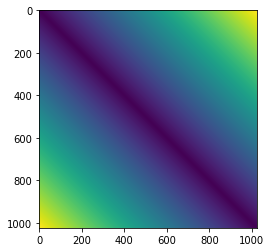

In [129]:
istoeplits = []
for i in range(len(c)-1):
    istoeplits.append((np.isclose(np.diag(c,i), np.diag(c,i)[0]).all()))
    
print('Toeplitz :', np.all(istoeplits))
plt.imshow(c)
plt.show()

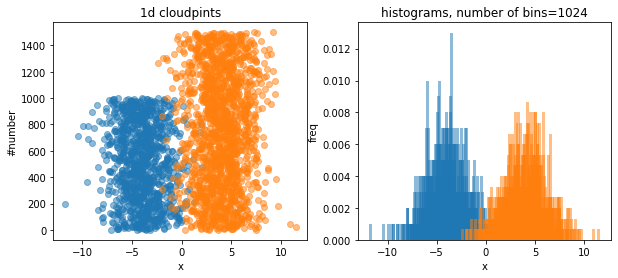

In [130]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('1d cloudpints')
plt.xlabel('x')
plt.ylabel('#number')
plt.scatter(X, range(len(X)), alpha=0.5)
plt.scatter(Y, range(len(Y)), alpha=0.5)
plt.subplot(122)
plt.title(f'histograms, number of bins={n}')
plt.xlabel('x')
plt.ylabel('freq')
plt.bar(bins, p, width=0.3, alpha=0.5, label='p')
plt.bar(bins, q, width=0.3, alpha=0.5, label='q')
plt.show()

In [131]:
p.shape, q.shape, c.shape

((1024,), (1024,), (1024, 1024))

In [132]:
p, q, bins

(array([0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ]),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00066667]),
 array([-11.7005457 , -11.67793623, -11.65532676, ...,  11.38371948,
         11.40632895,  11.42893842]))

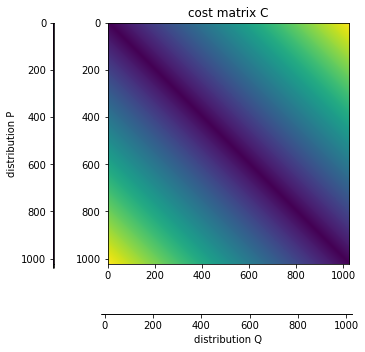

In [133]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.imshow(c)

# histogram on the attached axes
x_hist.imshow(q.reshape(1,-1))
y_hist.imshow(p.reshape(-1,1))
# y_hist.invert_yaxis()

main_ax.set_title('cost matrix C')
y_hist.set_ylabel('distribution P')
x_hist.set_xlabel('distribution Q')

plt.show()

#iterations=58, early stopping: tol, err=7.519608292972479e-17


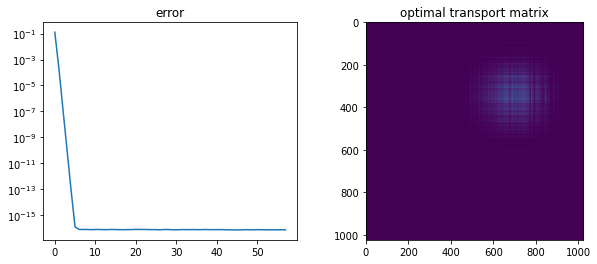

In [134]:
g, K, u, v = sinkhorn(p, q, c, 1, eps=1e-20, max_iter=2000, tol=1e-17, patience=50)

In [135]:
save = dict(p=p, q=q, bins=bins, K=K, u=u, v=v, c=c)

## another one 1d

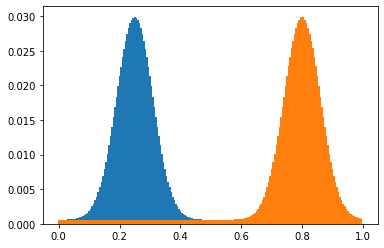

In [136]:
N = 200

t = np.arange(0,N)/N

Gaussian = lambda t0,sigma: np.exp(-(t-t0)**2/(2*sigma**2))
normalize = lambda p: p/np.sum(p)

sigma = .06;
a = Gaussian(.25,sigma)
b = Gaussian(.8,sigma)
vmin = .02;
a = normalize( a+np.max(a)*vmin)
b = normalize( b+np.max(b)*vmin)
plt.bar(t, a, width = 1/len(t))
plt.bar(t, b, width = 1/len(t))
plt.show()

Error=5.352991209463115e-10


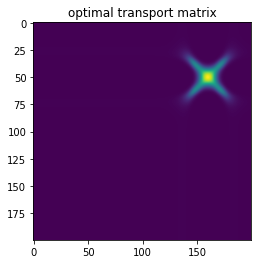

In [137]:
import ot
M = ot.dist(a.reshape(-1,1), b.reshape(-1,1))
# M = M /  M.max()
gamma = ot.sinkhorn(a, b, M, 5e-5)
print(f'Error={np.linalg.norm(gamma.sum(0) - b) + np.linalg.norm(gamma.sum(1) - a)}')
plt.imshow(gamma)
plt.title('optimal transport matrix')
plt.show()

#iterations=219, early stopping: tol, err=3.6496694522269297e-16


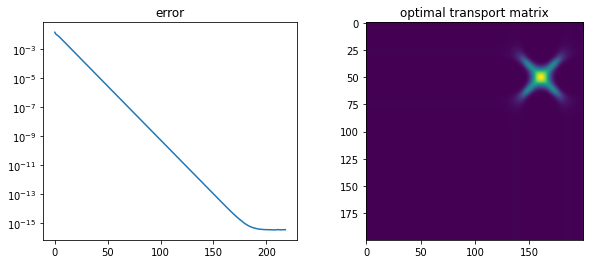

In [138]:
g, K, u, v = sinkhorn(a, b, M, 5e-5, eps=1e-20, max_iter=1000, tol=1e-15, patience=50)

# 2D bins

In [139]:
N, M, d = 200, 150, 2
X = np.random.normal(0, 3, (N, d))
Y = np.random.normal(10, 3, (M, d))

n, m = 32, 32

In [140]:
clouds = np.vstack([X, Y])

bins1 = centers(binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n, m)).bin_edges[0])
bins2 = centers(binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n, m)).bin_edges[1])
[x, y] = np.meshgrid(bins2, bins1, indexing='xy')
bins = np.hstack([x.reshape(-1,1), y[::-1].reshape(-1,1)])

c = cdist(bins, bins)

binsX = binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n, m), expand_binnumbers=True).binnumber[:,:len(X)] - 1
binsY = binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n, m), expand_binnumbers=True).binnumber[:,-len(Y):] - 1

idbX, cX = np.unique(binsX.T, return_counts=True, axis=0)
idbY, cY = np.unique(binsY.T, return_counts=True, axis=0)

In [141]:
p = np.zeros((n, m))
p[idbX[:,0], idbX[:,1]] = cX
p /= p.sum()

q = np.zeros((n, m))
q[idbY[:,0], idbY[:,1]] = cY
q /= q.sum()

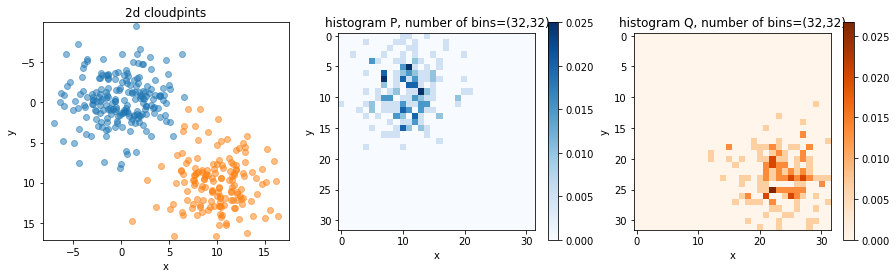

In [142]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('2d cloudpints')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.scatter(Y[:,0], Y[:,1], alpha=0.5)
plt.ylim(max(X.max(), Y.max()) + 0.5, min(X.min(), Y.min()) - 0.5)
plt.subplot(132)
plt.title(f'histogram P, number of bins=({n},{m})')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(p, cmap='Blues')
plt.colorbar()
plt.subplot(133)
plt.title(f'histogram Q, number of bins=({n},{m})')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(q, cmap='Oranges')
plt.colorbar()
plt.show()

#iterations=18, early stopping: tol, err=5.176492923024981e-17


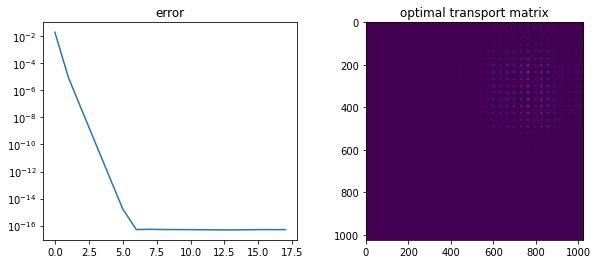

In [143]:
g, K, u, v = sinkhorn(p.ravel(), q.ravel(), c, 10, eps=1e-20, max_iter=1000, tol=1e-17, patience=10)

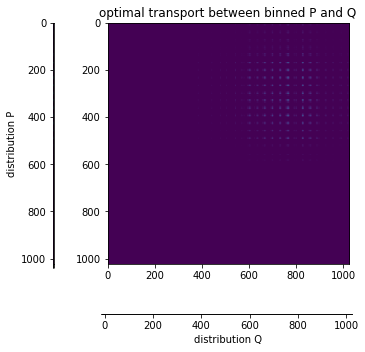

In [144]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.imshow(g)

# histogram on the attached axes
x_hist.imshow(q.reshape(1,-1))
x_hist.invert_yaxis()

y_hist.imshow(p.reshape(-1,1))
y_hist.invert_xaxis()

main_ax.set_title('optimal transport between binned P and Q')
y_hist.set_ylabel('distribution P')
x_hist.set_xlabel('distribution Q')

plt.show()

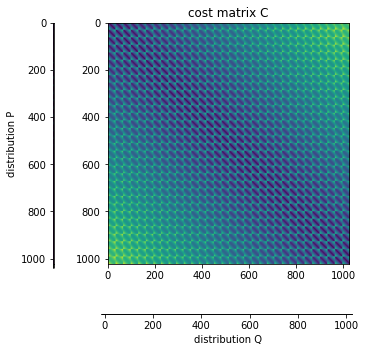

In [145]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.imshow(c)

# histogram on the attached axes
x_hist.imshow(q.reshape(1,-1))
x_hist.invert_yaxis()

y_hist.imshow(p.reshape(-1,1))
y_hist.invert_xaxis()

main_ax.set_title('cost matrix C')
y_hist.set_ylabel('distribution P')
x_hist.set_xlabel('distribution Q')

plt.show()

## Matvec Toeplitz

In [146]:
is_pow_2 = lambda x: x == 2 ** int(np.log2(x))

class Toeplitz(object):
    '''Class for utilizing Toeplitz matrix in Sinkhorn algorithm in 1D'''
    def __init__(self, C, beta):
        '''
        C - np.ndarray matrix of distances OR tuple of np.arrays (x, y) to compute distances
        beta - regularization parameter
        '''
        if isinstance(C, tuple):
            x, y = np.array(C[0], ndmin=2), np.array(C[1], ndmin=2)
            if x.shape[1] > 1 or x.ndim > 2:
                x = x.reshape(-1, 1)
            if y.shape[1] > 1 or y.ndim > 2:
                y = y.reshape(-1, 1)
            self.x_size, self.y_size = x.shape[0], y.shape[0] # N, N
            
            c1 = cdist(x, y[0].reshape(-1, 1)).ravel() # (N, )
            c2 = cdist(y, x[0].reshape(-1, 1))[:0:-1].ravel() # (N - 1, )
        elif isinstance(C, np.ndarray):
            assert C.ndim == 2 # (N, M)
            self.x_size, self.y_size = C.shape
            c1, c2 = C[:,0].ravel(), C[:0:-1].ravel()
        
        assert is_pow_2(self.x_size + self.y_size), 'matrix shape need to be power of 2'
        
        self.embedding = np.hstack([c1, [0], c2]) # (2N, )
        self.fembedding = np.exp(-self.embedding / beta)
        self.fft_vec = mkl_fft.fft(self.fembedding)
        self.size = self.fft_vec.shape[0]
    
    def dot(self, x):
        ''' fast "matvec" multiplication '''
        if x.ndim > 1:
            x = x.ravel()
        pad_width = self.size - x.shape[0]
        x_padded = np.pad(x, (0, pad_width))
        return np.abs(mkl_fft.ifft(self.fft_vec * mkl_fft.fft(x_padded))[:x.shape[0]])
    
    def full(self):
        ''' return full matrix np.exp(-C / beta)'''
        return sp.linalg.toeplitz(self.fembedding[:self.x_size], np.hstack([[0], self.fembedding[:self.x_size:-1]]))

In [147]:
### test

T = Toeplitz((save['bins'], save['bins']), 1)
assert np.isclose(T.full(), np.exp(-cdist(save['bins'].reshape(-1,1), save['bins'].reshape(-1,1)))).all()
assert np.isclose(save['p'] / np.abs(T.dot(save['v'])), save['u']).all()
assert np.isclose(save['q'] / np.abs(T.dot(save['u'])), save['v']).all() # T is symmetric

In [153]:
def sinkhorn_toeplitz(p, q, bins, beta=0.01, eps=1e-12, max_iter=200, tol=1e-10, patience=10, plot=True):
    '''
    p, q - distributions
    bins - coordinates of bins centers
    beta - regularization parameter 
    '''
    n, m = len(p), len(q)
    K = Toeplitz((bins, bins), beta)
    Kt = K # K is always symmetric?
    K_ = K.full()
    b = np.ones(m)
    err = [10]
    i = 0
    j = 0
    while i < max_iter:
        a = np.divide(p, K.dot(b))
        b = np.divide(q, Kt.dot(a))
        ######################################################### not optimized - TODO
        g = a.reshape(-1, 1) * K_ * b.reshape(1, -1)
        
        err.append(np.linalg.norm(g.sum(0) - q) + np.linalg.norm(g.sum(1) - p))
        #########################################################
        # if good enough
        if err[-1] < eps:
            print(f'#iterations={i+1}, early stopping: eps, err={err[-1]}')
            break
        # if no improvements
        if np.abs(err[-2] - err[-1]) < tol:
            j += 1
            if j > patience:
                print(f'#iterations={i+1}, early stopping: tol, err={err[-1]}')
                break
        else:
            j = 0
        i +=1
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title('error')
        plt.semilogy(range(len(err)-1), err[1:])
        plt.subplot(122)
        plt.title('optimal transport matrix')
        plt.imshow(g)
        plt.show()
    
    return g, K_, a, b

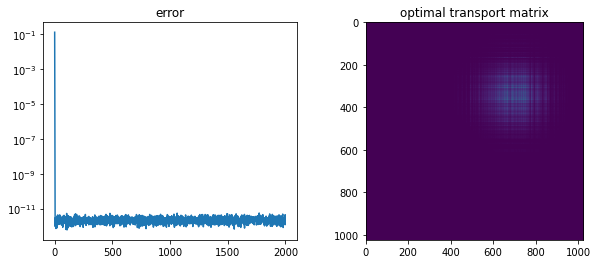

In [154]:
g, K, u, v = sinkhorn_toeplitz(save['p'], save['q'], save['bins'], 1, eps=1e-20, max_iter=2000, tol=1e-17, patience=50)

In [155]:
np.mean(u - save['u']), np.mean(v - save['v']), np.mean(K - save['K'])

(-2.5863233141328926e-12, 1.5958137950424357e-06, 1.0363559113481105e-16)

In [156]:
%timeit sinkhorn_toeplitz(save['p'], save['q'], save['bins'], 1, eps=1e-100, max_iter=1000, tol=1e-100, patience=50, plot=False)

1 loop, best of 3: 3.67 s per loop


In [157]:
%timeit sinkhorn(save['p'], save['q'], save['bins'], 1, eps=1e-100, max_iter=1000, tol=1e-100, patience=1000, plot=False)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


1 loop, best of 3: 6.14 s per loop


### Time comparison

In [159]:
results = []
for i in tqdm(range(5, 15)):
    N = 2 ** i
    X = np.random.rand(N, N) # matrix K
    x = np.random.rand(2 * N) # matrix K as vector
    y = np.random.rand(2 * N) # u (512) padded with zeros to (1024)
    fftx = np.fft.fft(x)
    
    tr = %timeit -q -o np.fft.ifft(fftx * np.fft.fft(y))
    results.append(tr.best)
    tr = %timeit -q -o sp.fft.ifft(fftx * sp.fft.fft(y))
    results.append(tr.best)
    tr = %timeit -q -o fftpack.ifft(fftx * fftpack.fft(y))
    results.append(tr.best)
    tr = %timeit -q -o mkl_fft.ifft(fftx * mkl_fft.fft(y))
    results.append(tr.best)
    
    tr = %timeit -q -o X.dot(y[:N])
    results.append(tr.best)

100%|██████████| 10/10 [02:57<00:00, 17.77s/it]


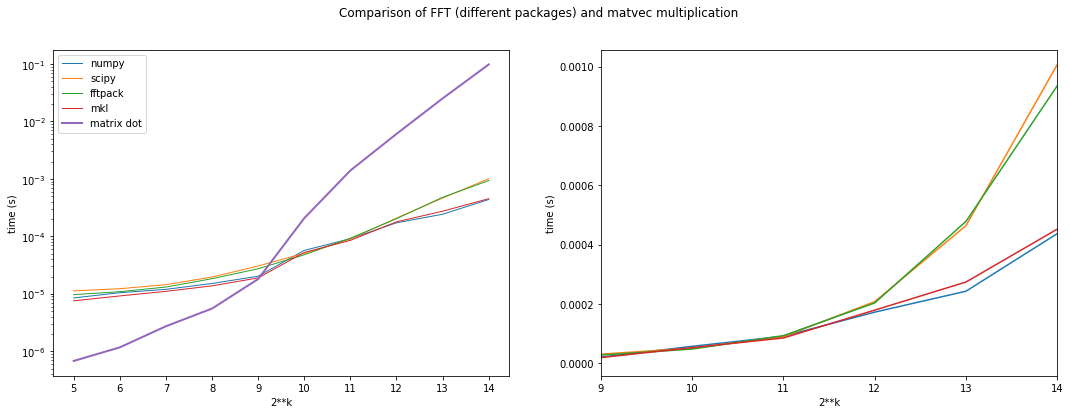

In [160]:
plt.figure(figsize=(18,6))
plt.suptitle('Comparison of FFT (different packages) and matvec multiplication')
plt.subplot(121)
plt.xlabel('2**k')
plt.ylabel('time (s)')
plt.xticks(range(10), range(5, 15))
plt.semilogy(results[0::5], linewidth=1, label='numpy')
plt.semilogy(results[1::5], linewidth=1, label='scipy')
plt.semilogy(results[2::5], linewidth=1, label='fftpack')
plt.semilogy(results[3::5], linewidth=1, label='mkl')
plt.semilogy(results[4::5], linewidth=2, label='matrix dot')
plt.legend()

plt.subplot(122)
plt.xlabel('2**k')
plt.ylabel('time (s)')
plt.xticks(range(10), range(5, 15))
plt.xlim(4, 9)
plt.plot(results[0::5])
plt.plot(results[1::5])
plt.plot(results[2::5])
plt.plot(results[3::5])
plt.show()